## Part 2: Multiclass linear classification
<a id=part2></a>
$
\renewcommand{\mat}[1]{\boldsymbol {#1}}
\renewcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\renewcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\renewcommand{\vec}[1]{\boldsymbol {#1}}
\renewcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\renewcommand{\diag}{\mathop{\mathrm {diag}}}
\renewcommand{\set}[1]{\mathbb {#1}}
\renewcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial {#1}}{\partial {#2}}}
$

In this part we'll learn about loss functions and how to optimize them with gradient descent.
We'll then use this knowledge to train a very simple model: a linear SVM.

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

### Linear Classification

<a id=part3_1></a>

In multi-class linear classification we have $C$ classes which we assume our samples
may belong to.
We apply a linear function to a sample $\vec{x} \in \set{R}^{D}$ and obtain a score $s_j$ which
represents how well $x$ fits the class $1\leq j\leq C$ according to our model:
$$
s_j = \vec{w_j} \vec{x} + b_j.
$$

Note that we have a different set of model parameters (weights) $\vec{w_j},~b_j$ for each class,
so a total of $C\cdot(D+1)$ parameters.

To classify a sample, we simply calculate the score for each class and choose the class with the
highest score as our prediction.

One interpretation of the weights $\vec{w_j},~b_j$ is that they represent the parameters of an
$N$-dimensional hyperplane. Under this interpretation the class score $s_j$ of a sample is proportional
to the distance of that sample from the hyperplane representing the $j$-th class. Note that this score
can be positive or negative (depending on which side of the hyperplane the sample is).
Such a classifier therefore splits the sample space into regions where the farther a sample is from the
positive side of a hyperplane for class $j$, the higher $s_j$, so the more likely it belongs to class $j$.

<center>
    <img src="https://waterprogramming.files.wordpress.com/2018/09/hyperplane1-e1538161721590.png" width="400"/>
</center>


#### Implementation

In the context of supervised learning of a linear classifier model, we map a dataset
(or batch from a dataset) of $N$ samples (for example, images flattened to vectors of length $D$)
to a score for one of each of $C$ possible classes using the linear function above.

To make the implementation efficient, we'll represent the mapping with a single matrix multiplication,
employing the "Bias trick": 
Instead of both $\vec{w_j}$ and $b_j$ per class, we'll put the bias term at the
beginning of the weight vector and add a term $1$ at the start of each sample.

The class scores for each sample are then given by:

$$
\mat{S} = \mat{X} \mat{W}
$$

Where here (and in the code examples you'll work with),
- $\mat{X}$ is a matrix of shape $N\times (D+1)$ containing $N$ samples in it's rows;
- $\mat{W}$ is of shape $(D+1)\times C$ and contains the learnable classifier parameters (weights and bias);
- $\mat{S}$ is therefore a $N\times C$ matrix of the class scores of each sample.

Notes: 
1. In the following discussions we'll use the notation $\vec{x_i}$ to denote the $i$-th training sample
   (row $i$ in $\mat{X}$) and $\vec{w_j}$ to denote the weights and bias for class $j$ (column $j$ in $\mat{W}$).
   However, when writing explicit vectors we treat them all as columns, so e.g. $\vec{w_j}\vec{x_i}$ is an
   inner product.
2. The reason we put the samples in the rows of $\mat{X}$ and not columns (as is the convention in some texts) is
   because that's the convention in the pytorch library: the batch dimension is always the first one. This has many
   implementation advantages.

**TODO** Implement the `BiasTrick` transform class in the module `hw1/transforms.py`.

In [2]:
import hw1.transforms as hw1tf

tf_btrick = hw1tf.BiasTrick()

test_cases = [
    torch.randn(64, 512),
    torch.randn(2, 3, 4, 5, 6, 7),
    torch.randint(low=0, high=10, size=(1, 12)),
    torch.tensor([10, 11, 12])
]

for x_test in test_cases:
    xb = tf_btrick(x_test)
    print('shape =', xb.shape)
    test.assertEqual(x_test.dtype, xb.dtype, "Wrong dtype")
    test.assertTrue(torch.all(xb[..., 1:] == x_test), "Original features destroyed")
    test.assertTrue(torch.all(xb[..., [0]] == torch.ones(*xb.shape[:-1], 1)), "First feature is not equal to 1")

shape = torch.Size([64, 513])
shape = torch.Size([2, 3, 4, 5, 6, 8])
shape = torch.Size([1, 13])
shape = torch.Size([4])


In [3]:
import torchvision.transforms as tvtf

# Define the transforms that should be applied to each image in the dataset before returning it
tf_ds = tvtf.Compose([
    # Convert PIL image to pytorch Tensor
    tvtf.ToTensor(),
    # Normalize each chanel with precomputed mean and std of the train set
    tvtf.Normalize(mean=(0.1307,), std=(0.3081,)),
    # Reshape to 1D Tensor
    hw1tf.TensorView(-1), 
    # Apply the bias trick (add bias element to features)
    hw1tf.BiasTrick(),
])

The following code will use your transform to load a subset of the [MNIST](http://yann.lecun.com/exdb/mnist/)
dataset for us to work with.

In [4]:
import hw1.datasets as hw1datasets
import hw1.dataloaders as hw1dataloaders

# Define how much data to load
num_train = 10000
num_test = 1000
batch_size = 1000

# Training dataset
data_root = os.path.expanduser('~/.pytorch-datasets')
ds_train = hw1datasets.SubsetDataset(
    torchvision.datasets.MNIST(root=data_root, download=True, train=True, transform=tf_ds),
    num_train)

# Create training & validation sets
dl_train, dl_valid = hw1dataloaders.create_train_validation_loaders(
    ds_train, validation_ratio=0.2, batch_size=batch_size
)

# Test dataset & loader
ds_test = hw1datasets.SubsetDataset(
    torchvision.datasets.MNIST(root=data_root, download=True, train=False, transform=tf_ds),
    num_test)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size)

x0, y0 = ds_train[0]
n_features = torch.numel(x0)
n_classes = 10

# Make sure samples have bias term added
test.assertEqual(n_features, 28*28*1+1, "Incorrect sample dimension")

**TODO** Complete the implementation of the `__init()__`, `predict()` and `evaluate_accuracy()` functions in the
`LinearClassifier` class located in the `hw1/linear_classifier.py` module.


In [5]:
import hw1.linear_classifier as hw1linear

# Create a classifier
lin_cls = hw1linear.LinearClassifier(n_features, n_classes)

# Evaluate accuracy on test set
mean_acc = 0
for (x,y) in dl_test:
    y_pred, _ = lin_cls.predict(x)
    mean_acc += lin_cls.evaluate_accuracy(y, y_pred)
mean_acc /= len(dl_test)

print(f"Accuracy: {mean_acc:.1f}%")

Accuracy: 6.4%


You should get an accuracy of around 10%, corresponding to a random guess of one of ten classes. You can run the above code block multiple times to sample different initial weights and get slightly different results.

### Loss Functions
<a id=part3_2></a>

We have seen that a linear model computes the class scores for each sample using a linear mapping as
a score function.
However in order to train the model, we need to define  some measure of how
well we've classified our samples compared to their ground truth labels.
This measure is known as a **loss function**, and it's selection is crucial in determining the model
that will result from training. A loss function produces lower values the better the classification is.

#### Multiclass SVM loss function

A very common linear model for classification is the Support Vector Machine. An SVM attempts to find
separating hyperplanes that have the property of creating a maximal margin to the training samples, i.e.
hyperplanes that are as far as possible from the closest training samples.
For example, in the following image we see a simple case with two classes of samples that have only two features.
The data is linearly separable and it's easy to see there are infinite possible hyperplanes (in this case lines)
that separate the data perfectly.

The SVM model finds the optimal hyperplane, which is the one with
the maximal margin. The data points closest to the separating hyperplane are called the Support Vectors
(it can be shown that only they determine the hyperplane).
We can see that the width of the margin is $\frac{2}{|\vec{w}|}$. In this simple case since the data is linearly
separable, there exists a solution where no samples fall within the margin. If the data is not linearly separable, we
need to allow samples to enter the margin (with a cost). This is known as a soft-margin SVM.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/2a/Svm_max_sep_hyperplane_with_margin.png" width=400 alt="svm"/>

There are many ways to train an SVM model. Classically, the problem is stated as constrained optimization and
solved with quadratic optimization techniques.
In this exercise, we'll instead work directly with the uncontrained SVM loss function,
calculate it's gradient analytically, and then minimize it with gradient descent.
As we'll see in the rest of the course, this technique will be a
major component when we train deep neural networks.


The **in-sample** (empirical) loss function for a multiclass soft-margin SVM can be stated as follows:

$$
L(\mat{W}) =
\frac{1}{N} \sum_{i=1}^{N} L_{i}(\mat{W})
+
\frac{\lambda}{2} |\mat{W}|^2
$$

Where the first term is the mean pointwise data-dependent loss $L_{i}$,
given by the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss) formula,

$$
L_{i}(\mat{W}) =  \sum_{j \neq y_i} \max\left(0, \Delta+ \vectr{w_j} \vec{x_i} - \vectr{w_{y_i}} \vec{x_i}\right),
$$

and the second term is a regularization loss which depends only on model parameters.
Note that the hinge loss term sums over the *wrong* class prediction scores for each sample:
$j\neq y_i$, and $y_i$ is the ground-truth label for sample $i$.
This can be understood as attempting to make sure that the score for the correct class is higher than the other 
classes by
at least some margin $\Delta > 0$, otherwise a loss is incurred.
This way, we allow samples to fall within the margin but incur loss, which gives us a soft-margin SVM.

The regularization term penalizes large weight magnitudes to prevent ambiguous solutions since if 
e.g. $\mat{W^*}$ is a weight matrix that perfectly separates the data, so is $\alpha\mat{W^*}$ for
any scalar $\alpha \geq 1$.

Fitting an SVM model then amounts to finding the weight matrix $\mat{W}$ which minimizes $L(\mat{W})$.
Note that we're writing the loss as a function of $\mat{W}$ to
emphasize that we wish to minimize it's value on the given data by with respect to the weights $\mat{W}$,
even though it obviously depends also on our specific dataset, $\left\{ \vec{x_i}, y_i \right\}_{i=1}^{N}$.

    #### Implementation

**TODO** Implement the SVM hinge loss function in the module `hw1/losses.py`, within the `SVMHingeLoss` class.
Implement just the `loss()` function. For now you can ignore the part about saving tensors for the gradient calculation. Run the following to test.

In [6]:
import cs236781.dataloader_utils as dl_utils
from hw1.losses import SVMHingeLoss

torch.random.manual_seed(42)

# Classify all samples in the test set
# because it doesn't depend on randomness of train/valid split
x, y = dl_utils.flatten(dl_test)

# Compute predictions
lin_cls = hw1linear.LinearClassifier(n_features, n_classes)
y_pred, x_scores = lin_cls.predict(x)

# Calculate loss with our hinge-loss implementation
loss_fn = SVMHingeLoss(delta=1.)
loss = loss_fn(x, y, x_scores, y_pred)

# Compare to pre-computed expected value as a test
expected_loss = 9.0233
print("loss =", loss.item())
print('diff =', abs(loss.item()-expected_loss))
test.assertAlmostEqual(loss.item(), expected_loss, delta=1e-2)

loss = 9.023382186889648
diff = 8.218688964767296e-05


### Optimizing a Loss Function with Gradient Descent
<a id=part3_3></a>

In this section we'll implement a simple gradient descent optimizer for the loss function we've implemented above. As you have seen in the lectures, the basic gradient-based optimization scheme is as follows:

1. Start with initial model weights $\mat{W_0}$ initialized randomly.
1. For $k=1,2,\dots,K$:
    1. Select a step size $\eta_k$.
    1. Compute the gradient of the loss w.r.t. $\mat{W}$ and evaluate at the current weights:
        $\nabla_{\mat{W}} L(\mat{W_{k-1}})$.
    1. Update: 
        $$
        \mat{W_k} = \mat{W_{k-1}} - \eta_k \nabla_{\mat{W}} L(\mat{W_{k-1}})
        $$
    1. Stop if minimum reached or validation-set loss is low enough.

The crucial component here is the gradient calculation.
In this exercise we'll analytically derive the gradient
of the loss and then implement it in code.
In the next parts of the course we'll enjoy the automatic-differentiation features of PyTorch,
but for now we'll do it the old-fashioned way.

An important detail to note is that while $L(\mat{W})$ is scalar-valued, it's a function of all the elements of the
matrix $\mat{W}$. Therefore it's gradient w.r.t. $\mat{W}$ is also a matrix of the same shape as $\mat{W}$:

$$
\nabla_{\mat{W}} L =
\begin{bmatrix}
    \frac{\partial L}{\partial W_{1,1}} & & \cdots & \frac{\partial L}{\partial W_{1,C}} \\
    \frac{\partial L}{\partial W_{2,1}} & \ddots &  \\
    \vdots & & \ddots &  \\
    \frac{\partial L}{\partial W_{D+1,1}} & \cdots &  & \frac{\partial L}{\partial W_{D+1,C}} \\
\end{bmatrix} =
\begin{bmatrix}
\vert & & \vert \\
\frac{\partial L}{\partial\vec{w_1}} & \cdots & \frac{\partial L}{\partial\vec{w_C}}\\
\vert & & \vert \\
\end{bmatrix}
\in \set{R}^{(D+1)\times C}.
$$

For our gradient descent update-step we'll need to create such a matrix of derivatives and evaluate it at the 
current value of the weight matrix.

#### SVM loss gradient

The first thing we need to do is formulate an expression for the gradient of the loss function defined above. Since the expression for the loss depends on the columns of $\mat{W}$, we'll derive an expression for the gradient of $L(\mat{W})$ w.r.t. each $\vec{w_j}$:

$$
\pderiv{L}{\vec{w_j}}(\mat{W}) = 
\frac{1}{N} \sum_{i=1}^{N} \pderiv{L_{i}}{\vec{w_j}}(\mat{W})
+
\lambda \vec{w_j}.
$$

To compute the gradient of the pointwise loss, let's define the **margin-loss** of sample $i$ for class $j$
as follows: $m_{i,j} = \Delta + \vec{w_j}\vec{x_i} - \vec{w_{y_i}}\vec{x_i}$.
We can then write the pointwise loss and it's gradient in terms of $m_{i,j}$. We'll separate the case of $j=y_i$
(i.e. the gradient for the correct class):

$$
\begin{align}
    \pderiv{L_i}{\vec{w_j}} & =
        \begin{cases}
            \vec{x_i}, & m_{i,j}>0 \\
            0, & \mathrm{else} \\
        \end{cases}
    ,~j \neq y_i \\
    \\
    \pderiv{L_i}{\vec{w_{y_i}}} & = -\vec{x_i} \sum_{j\neq y_i} \mathbb{1}\left( m_{i,j} > 0 \right)
\end{align}
$$

Where $\mathbb{1}(\cdot)$ is an indicator function that takes the value $1$ if it's argument is a true statement, else it takes $0$.

Note: the hinge-loss function is not strictly speaking differentiable due to the $\max$ operator.
However, in practice it's not a major concern.
Given that we know what argument the $\max$ "chooses",
we can differentiate each one of them separately.
This is known as a **sub-gradient**.
In the above, when $m_{i,j} \leq 0$ we know the gradient will simply be zero.

**TODO** Based on the above, implement the gradient of the loss function in the module `hw1/losses.py`,
within the `SVMHingeLoss` class.
Implement the `grad()` function and complete what's missing in the `loss()` function.
Make sure you understand the above gradient derivation before attempting to implement it.

Note: you'll be implementing **only the first term** in the above equation for $\pderiv{L}{\vec{w_j}}(\mat{W})$. We'll add the regularization term later.

In [7]:
# Create a hinge-loss function
loss_fn = SVMHingeLoss(delta=1)

# Compute loss and gradient
loss = loss_fn(x, y, x_scores, y_pred)
grad = loss_fn.grad()

# Sanity check only (not correctness): compare the shape of the gradient
test.assertEqual(grad.shape, lin_cls.weights.shape)

But in the above we only checked the shape, how do we know if we've implemented the gradient correctly?

One approach is to recall the formal definition of the derivative, i.e.
$$
f'(x)=\lim_{h\to 0} \frac{f(x+h)-f(x)}{h}.
$$
Another way to put this is that for a *small enough* $h$,
$$
f(x+h)\approx f(x)+f'(x)\cdot h.
$$

We can use this approach to implement a gradient check by applying very small perturbations
of each weight (separately) and using the above formula to check the correctness of the gradient
(up to some tolerance). This is called a **numerical** gradient check.


Here we'll use a different approach, just to get a taste of the concept of
**automatic differentiation**, which we'll rely on heavily in the rest of the course.

In the simple linear model we worked with, the gradient was fairly straightforward to derive analytically
and implement.
However for complex models such as deep neural networks with many layers and non-linear operations between
them this is not the case. Additionally, the gradient must be re-derived any time either the model
architecture or the loss function changes. These things make it infeasible in practice to perform
deep-learning research using this manual method of gradient derivation.
Therefore, all deep-learning frameworks provide a mechanism of [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), to prevent
the user from needing to manually derive the gradients of loss functions.

`PyTorch` provides this functionality in a package named `torch.autograd` which we will use further on in the
next exercises.
For now, here's an example showing that autograd can compute the gradient of the loss function you've implemented.

**TODO** Run the following code block. Try to understand how autograd is used and why. If the test fails, go back and fix your gradient calculation.

In [8]:
from hw1.losses import SVMHingeLoss

# Create a new classifier and loss function
lin_cls = hw1linear.LinearClassifier(n_features, n_classes)
loss_fn = SVMHingeLoss(delta=1)

# Specify we want the gradient to be saved for the weights tensor
# (just for our test)
lin_cls.weights.requires_grad = True

# Forward pass using the weights tensor, calculations will be tracked
y_pred, x_scores = lin_cls.predict(x)

# Compute loss of predictions and their analytic gradient
loss = loss_fn(x, y, x_scores, y_pred)
grad = loss_fn.grad()

# Compute gradient with autograd
autograd_grad = torch.autograd.grad(loss, lin_cls.weights)[0]

# Calculate the difference between analytic and autograd
diff = torch.norm(grad - autograd_grad).item()
print('loss =', loss.item())
print('grad =\n', grad)
print('autograd =\n', autograd_grad)
print('diff =', diff)

test.assertLess(diff, 1e-3, "Gradient diff was too large")

loss = 8.961071968078613
grad =
 tensor([[ 0.1500, -0.2600, -0.1600,  ...,  0.0100,  0.1100,  0.0600],
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255],
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255],
        ...,
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255],
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255],
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255]])
autograd =
 tensor([[ 0.1500, -0.2600, -0.1600,  ...,  0.0100,  0.1100,  0.0600],
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255],
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255],
        ...,
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255],
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255],
        [-0.0636,  0.1103,  0.0679,  ..., -0.0042, -0.0467, -0.0255]])
diff = 2.1328363800421357e-05


### Training the model with SGD
<a id=part3_4></a>

Generally, solving a machine-learning problem requires defining the following components:
- A model:
  architecture (type of model) consisting of hyperparameters (e.g. number of hidden layers, number of classes, etc)
  which are set in advance and trainable parameters which we want to fit to data.
- A loss function (sometimes denoted as a criterion):
  evaluates the model output on some data compared to ground truth.
- An optimization scheme:
  specifies how the model should be updated to improve the loss. May also have hyperparameters.
- A dataset:
  What to fit the model to. Usually the available data is split into training, validation and test sets.

Now that we have implemented our loss function and it's gradient, we can finally train our model.

Implementation notes:
- You'll find that when implementing your solutions it's wise to keep the above components separate as to be
  able to change each one of them independently from the other.
- In this exercise we'll have separated the loss and dataset, however for simplicity we'll implement the
  model and optimizer together.
- As you'll see further on, `PyTorch` provides very effective mechanisms to implement all of
  these components in a decoupled manner.
- Note that our loss implementation **didn't include regularization**. We'll add this during the training phase
  using the `weight_decay` parameter. The reason is that we prefer that the part of the loss which only depends
  on the model parameters be part of the optimizer, not the loss function (though both ways are possible).
  You'll see this pattern later on when you use `PyTorch`'s optimizers in the `torch.optim` package.
- In practice we use batches of samples from the training set when training the model, because usually the training
  set can't fit into memory. Using gradients computed on batches of data at a time is known as mini-batch
  stochastic gradient descent (SGD).

**TODO** 
1. Implement the model training loop in the `LinearClassifier`'s `train()` method.
   Use mini-batch SGD for the weight update rule.
1. Update the training hyperparameters in the `hyperparams` function.
   You should play with the hyperparameters to get a feel for what they do to the
   loss and accuracy graphs.

hyperparams = {'weight_std': 0.1, 'learn_rate': 0.05, 'weight_decay': 0.0001}
Training..............................
Test-set accuracy before training: 13.5%
Test-set accuracy after training: 86.0%


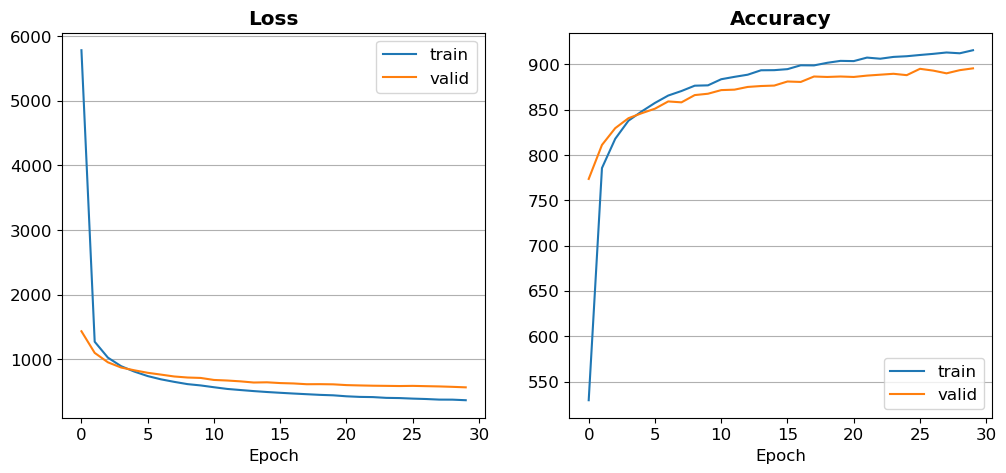

In [9]:
hp = hw1linear.hyperparams()
print('hyperparams =', hp)

lin_cls = hw1linear.LinearClassifier(n_features, n_classes, weight_std=hp['weight_std'])

# Evaluate on the test set
x_test, y_test = dl_utils.flatten(dl_test)
y_test_pred , _= lin_cls.predict(x_test)
test_acc_before = lin_cls.evaluate_accuracy(y_test, y_test_pred)

# Train the model
svm_loss_fn = SVMHingeLoss()
train_res, valid_res = lin_cls.train(dl_train, dl_valid, svm_loss_fn,
                                    learn_rate=hp['learn_rate'], weight_decay=hp['weight_decay'],
                                    max_epochs=30)

# Re-evaluate on the test set
y_test_pred , _= lin_cls.predict(x_test)
test_acc_after = lin_cls.evaluate_accuracy(y_test, y_test_pred)

# Plot loss and accuracy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for i, loss_acc in enumerate(('loss', 'accuracy')):
    axes[i].plot(getattr(train_res, loss_acc))
    axes[i].plot(getattr(valid_res, loss_acc))
    axes[i].set_title(loss_acc.capitalize(), fontweight='bold')
    axes[i].set_xlabel('Epoch')
    axes[i].legend(('train', 'valid'))
    axes[i].grid(which='both', axis='y')
    
# Check test set accuracy
print(f'Test-set accuracy before training: {test_acc_before:.1f}%')
print(f'Test-set accuracy after training: {test_acc_after:.1f}%')
test.assertGreaterEqual(test_acc_after, 85.0)

Even though this is a very naïve model, you should get at least 85% test set accuracy if you implemented training correctly. You can try to change the hyperparameters and see whether you get better results. Generally this should be done with cross-validation.

#### Visualization

One way to understand what models learn is to try to visualize their learned parameters.
There can be many ways to do this. Let's try a very simple one, which is to reshape them into images of the input
size and see what they look like.

**TODO** Implement the `weights_as_images()` function in the `LinearClassifier` class.

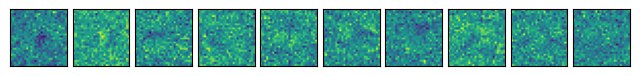

In [10]:
import cs236781.plot as plot

w_images = lin_cls.weights_as_images(img_shape=(1,28,28))
fig, axes = plot.tensors_as_images(list(w_images))

Additionally, we can better understand the model by plotting some samples and looking at wrong predictions.
Run the following block to visualize some test-set examples and the model's predictions for them.

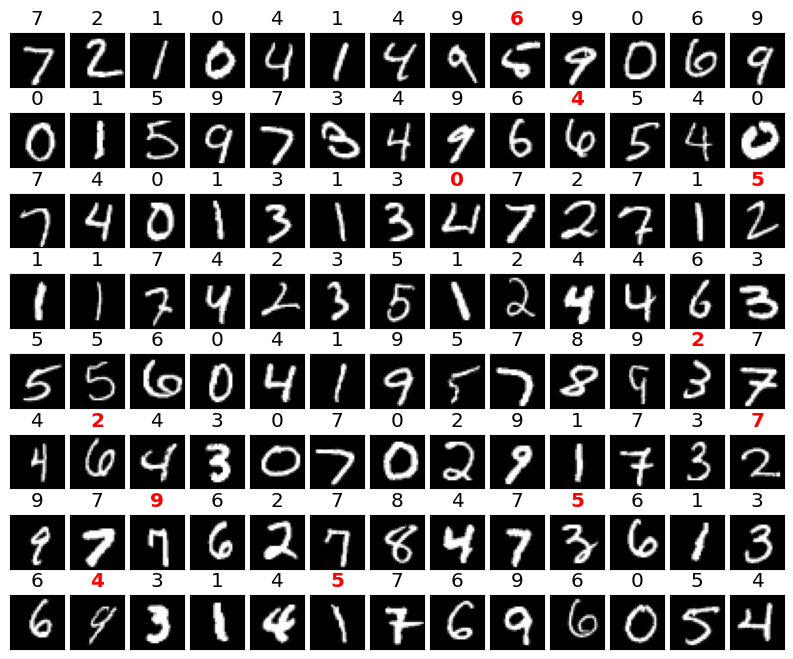

In [12]:
# Plot some images from the test set and their predictions
n_plot = 104
x_test, y_test = next(iter(dl_test))
x_test = x_test[0:n_plot]
y_test = y_test[0:n_plot]
y_test_pred, _ = lin_cls.predict(x_test)
x_test_img = torch.reshape(x_test[:, :-1], (n_plot, 1, 28, 28))

fig, axes = plot.tensors_as_images(list(x_test_img), titles=y_test_pred.numpy(),
                                   nrows=8, hspace=0.5, figsize=(10,8), cmap='gray')

# Highlight the wrong predictions
wrong_pred = y_test_pred != y_test
wrong_pred_axes = axes.ravel()[wrong_pred.numpy().astype(bool)]
for ax in wrong_pred_axes:
    ax.title.set_color('red')
    ax.title.set_fontweight('bold')

### Questions

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw1/answers.py`.


In [ ]:
from cs236781.answers import display_answer
import hw1.answers

#### Question 1 

Explain what happen if we allow $\Delta < 0$  for the SVM loss $L(\mat{W})$ as it is defined above (the full in-sample loss, with the regularization term).


In [ ]:
display_answer(hw1.answers.part2_q1)

#### Question 2

Given the images in the visualization section above,

How do you interpret what the linear model is actually learning? Can you explain some of the classification
   errors based on it?

In [ ]:
display_answer(hw1.answers.part2_q2)

#### Question 3

1. Based on the graph of the training set loss, would you say that the learning rate you chose is:
    - Too low
    - Good
    - Too High
    
  Explain your answer by describing what the loss graph would look like in the other two cases when training
  for the same number of epochs.
  
1. Based on the graph of the training and test set accuracy, would you say that the model is:
    - Slightly overfitted to the training set
    - Highly overfitted to the training set
    - Slightly underfitted to the training set
    - Highly underfitted to the training set
    
  and why?

In [ ]:
display_answer(hw1.answers.part2_q3)